In [1]:
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
import pyro.poutine as poutine
import matplotlib.pyplot as plt
from PIL import Image

from RAVDESS_dataset_util import *
from EmoClassCNN import *

torch.set_default_dtype(torch.float64)

pyro.enable_validation(False)

In [2]:
folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames'

In [3]:
NUM_CLASSES = len(emocat)
IMG_SIZE = 64
BATCH_SIZE = 32
DEFAULT_Z_DIM = 50

face_dataset = FaceEmotionDataset(root_dir=folder_path,
                                    transform=transforms.Compose([
                                        Rescale(IMG_SIZE), 
                                        CenterCrop(IMG_SIZE), 
                                        ToTensor()
                                    ]))        

dataset_loader = DataLoader(face_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=20)

print(len(face_dataset))

7200


(64, 64, 3)


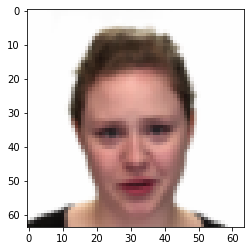

In [4]:
img = np.array(next(iter(face_dataset))['image']).transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

In [5]:
def emotion_rating_conversion(cat):
    ratings = torch.zeros(NUM_CLASSES)
    ratings[cat] = 1
    return ratings
    
#torch.argmax(emotion_rating_conversion(3))

In [6]:
# helper functions
class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""
    def forward(self, x):
        return x * torch.sigmoid(x)

def swish(x):
    return x * torch.sigmoid(x)

In [7]:
class ProductOfExperts(nn.Module):
    """
    Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param loc: M x D for M experts
    @param scale: M x D for M experts
    """
    def forward(self, loc, scale, eps=1e-8):
        scale = scale + eps # numerical constant for stability
        # precision of i-th Gaussian expert (T = 1/sigma^2)
        T = 1. / scale
        product_loc = torch.sum(loc * T, dim=0) / torch.sum(T, dim=0)
        product_scale = 1. / torch.sum(T, dim=0)
        return product_loc, product_scale
      
class ImageEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|image).
    This goes from images to the latent z
    
    This is the standard DCGAN architecture.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(ImageEncoder, self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            Swish(),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            Swish())
        # Here, we define two layers, one to give z_loc and one to give z_scale
        self.z_loc_layer = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), # it's 256 * 5 * 5 if input is 64x64.
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        self.z_scale_layer = nn.Sequential(
            nn.Linear(256 * 5 * 5, 512), # it's 256 * 5 * 5 if input is 64x64.
            Swish(),
            nn.Dropout(p=0.1),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, image):
        hidden = self.features(image)
        hidden = hidden.view(-1, 256 * 5 * 5)  # it's 256 * 5 * 5 if input is 64x64.
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden)) #add exp so it's always positive
        return z_loc, z_scale
    
class ImageDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(image|z).
    This goes from the latent z to the images
    
    This is the standard DCGAN architecture.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(ImageDecoder, self).__init__()
        self.upsample = nn.Sequential(
            nn.Linear(z_dim, 256 * 5 * 5), # it's 256 * 5 * 5 if input is 64x64.
            Swish())
        self.hallucinate = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            Swish(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            Swish(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            Swish(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False))

    def forward(self, z):
        # the input will be a vector of size |z_dim|
        z = self.upsample(z)
        z = z.view(-1, 256, 5, 5) # it's 256 * 5 * 5 if input is 64x64.
        image = self.hallucinate(z) # this is the image
        return image  # NOTE: no sigmoid here. See train.py

In [8]:
class EmotionEncoder(nn.Module):
    """
    define the PyTorch module that parametrizes q(z|emotion category).
    This goes from ratings to the latent z

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim, use_cuda=True):
        super(EmotionEncoder, self).__init__()
        self.net = nn.Linear(NUM_CLASSES, 512)
        
        self.z_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        
        self.z_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, z_dim))
        self.z_dim = z_dim

    def forward(self, emocat):
        hidden = self.net(emocat)
        z_loc = self.z_loc_layer(hidden)
        z_scale = torch.exp(self.z_scale_layer(hidden))
        return z_loc, z_scale


class EmotionDecoder(nn.Module):
    """
    define the PyTorch module that parametrizes p(emotion category|z).
    This goes from the latent z to the ratings

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
    """
    def __init__(self, z_dim):
        super(EmotionDecoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),
            Swish())
        
        self.emotion_loc_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, NUM_CLASSES))
        
        self.emotion_scale_layer = nn.Sequential(
            nn.Linear(512, 512),
            Swish(),
            nn.Linear(512, NUM_CLASSES))

    def forward(self, z):
        #batch_size = z.size(0)
        hidden = self.net(z)
        emotion_loc = self.emotion_loc_layer(hidden)
        emotion_scale = torch.exp(self.emotion_scale_layer(hidden))
        # rating is going to be a |emotions| * 9 levels
        #rating = h.view(batch_size, EMOTION_VAR_DIM, 9)
        return emotion_loc, emotion_scale  # NOTE: no softmax here. See train.py

In [9]:
class MVAE(nn.Module):
    """
    This class encapsulates the parameters (neural networks), models & guides needed to train a
    multimodal variational auto-encoder.
    Modified from https://github.com/mhw32/multimodal-vae-public
    Multimodal Variational Autoencoder.

    @param z_dim: integer
                  size of the tensor representing the latent random variable z
                  
    Currently all the neural network dimensions are hard-coded; 
    in a future version will make them be inputs into the constructor
    """
    def __init__(self, z_dim, img_size=128, use_cuda=True):
        super(MVAE, self).__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.experts = ProductOfExperts()
        self.image_encoder = ImageEncoder(z_dim)
        self.image_decoder = ImageDecoder(z_dim)
        self.emotion_encoder = EmotionEncoder(z_dim)
        self.emotion_decoder = EmotionDecoder(z_dim)
        
        self.use_cuda = use_cuda
        # relative weights of losses in the different modalities
        self.LAMBDA_IMAGES = 1.0
        self.LAMBDA_RATINGS = 50.0
        
        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()
            
    def model(self, images=None, emotions=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
        
        with pyro.plate("data"):      
            # sample the latent z from the (constant) prior, z ~ Normal(0,I)
            z_prior_loc  = torch.zeros(size=[batch_size, self.z_dim])
            z_prior_scale = torch.exp(torch.zeros(size=[batch_size, self.z_dim]))     
            
            if self.use_cuda:
                z_prior_loc, z_prior_scale = z_prior_loc.cuda(), z_prior_scale.cuda()
            
            # sample from prior (value will be sampled by guide when computing the ELBO)
            with poutine.scale(scale=annealing_beta):
                z = pyro.sample("z", dist.Normal(z_prior_loc, z_prior_scale))

            # decode the latent code z (image decoder)
            img_loc = self.image_decoder.forward(z)
            
            # score against actual images
            if images is not None:
                with poutine.scale(scale=self.LAMBDA_IMAGES):
                    #img_loc = (img_loc - torch.min(img_loc)) / (torch.max(img_loc) - torch.min(img_loc))
                    pyro.sample("obs_img", dist.Bernoulli(img_loc), obs=images)
            
            # decode the latent code z (emotion decoder)
            emotion_loc, emotion_scale = self.emotion_decoder.forward(z)
            if emotions is not None:
                with poutine.scale(scale=self.LAMBDA_RATINGS):
                    pyro.sample("obs_emotion", dist.Normal(emotion_loc, emotion_scale), obs=emotions)

            # return the loc so we can visualize it later
            return img_loc, emotion_loc
        
    def guide(self, images=None, emotions=None, annealing_beta=1.0):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("mvae", self)
        
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
            
        with pyro.plate("data"):
            # use the encoder to get the parameters used to define q(z|x)
                        
            # initialize the prior expert.
            # we initalize an additional dimension, along which we concatenate all the 
            #   different experts.
            # self.experts() then combines the information from these different modalities
            #   by multiplying the gaussians together
            
            z_loc = torch.zeros(torch.Size((1, batch_size, self.z_dim))) + 0.5
            z_scale = torch.ones(torch.Size((1, batch_size, self.z_dim))) * 0.1
            
            if self.use_cuda:
                z_loc, z_scale = z_loc.cuda(), z_scale.cuda()
                
            if images is not None:
                image_z_loc, image_z_scale = self.image_encoder.forward(images)
                z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)
            
            if emotions is not None:
                emotion_z_loc, emotion_z_scale = self.emotion_encoder.forward(emotions)
                z_loc = torch.cat((z_loc, emotion_z_loc.unsqueeze(0)), dim=0)
                z_scale = torch.cat((z_scale, emotion_z_scale.unsqueeze(0)), dim=0)
            
            z_loc, z_scale = self.experts(z_loc, z_scale)
            # sample the latent z
            with poutine.scale(scale=annealing_beta):
                pyro.sample("z", dist.Normal(z_loc, z_scale))
                
                
    def forward(self, image=None, emotion=None):
        z_loc, z_scale  = self.infer(image, emotion)
        z = pyro.sample("z", dist.Normal(z_loc, z_scale).independent(1))
        # reconstruct inputs based on that gaussian
        image_recon = self.image_decoder(z)
        rating_recon = self.emotion_decoder(z)
        return image_recon, rating_recon, z_loc, z_scale
    
    
    def infer(self, images=None, emotions=None):
        batch_size = 0
        if images is not None:
            batch_size = images.size(0)
        elif emotions is not None:
            batch_size = emotions.size(0)
            
        # initialize the prior expert
        # we initalize an additional dimension, along which we concatenate all the 
        #   different experts.
        # self.experts() then combines the information from these different modalities
        #   by multiplying the gaussians together
        z_loc = torch.zeros(torch.Size((1, BATCH_SIZE, self.z_dim))) + 0.5
        z_scale = torch.ones(torch.Size((1, BATCH_SIXE, self.z_dim))) * 0.1
        
        if self.use_cuda:
            z_loc, z_scale = z_loc.cuda(), z_scale.cuda()

        if images is not None:
            image_z_loc, image_z_scale = self.image_encoder.forward(images)
            z_loc = torch.cat((z_loc, image_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, image_z_scale.unsqueeze(0)), dim=0)

        if emotions is not None:
            emotion_z_loc, emotion_z_scale = self.emotion_encoder.forward(emotions)
            z_loc = torch.cat((z_loc, emotion_z_loc.unsqueeze(0)), dim=0)
            z_scale = torch.cat((z_scale, emotion_z_scale.unsqueeze(0)), dim=0)

        z_loc, z_scale = self.experts(z_loc, z_scale)
        return z_loc, z_scale

    
    # define a helper function for reconstructing images
    def reconstruct_img(self, images):
        # encode image x
        z_loc, z_scale = self.image_encoder(images)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc = self.image_decoder.forward(z)
        return img_loc

    
    # define a helper function for reconstructing images without sampling
    def reconstruct_img_nosample(self, images):
        # encode image x
        z_loc, z_scale = self.image_encoder(images)
        ## sample in latent space
        #z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        img_loc = self.image_decoder.forward(z_loc)
        return img_loc

In [10]:
import gc

gc.collect()
torch.cuda.empty_cache()

pyro.clear_param_store()

class Args:
    learning_rate = 1e-5
    weight_decay = 1e-6
    num_epochs = 200 #500
    z_dim = DEFAULT_Z_DIM
    img_size = IMG_SIZE
    seed = 30
    cuda = True
    
args = Args()

# setup the optimizer
adam_args = {"lr": args.learning_rate}#, "weight_decay":args.weight_decay}
optimizer = Adam(adam_args)

# setup the VAE
mvae = MVAE(z_dim=args.z_dim, img_size=args.img_size, use_cuda=args.cuda)

# setup the inference algorithm
svi = SVI(mvae.model, mvae.guide, optimizer, loss=Trace_ELBO())

In [11]:
from tqdm import tqdm

train_elbo = []
# training loop
for epoch in tqdm(range(args.num_epochs)):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch returned
    # by the data loader
    for batch_num, sample in enumerate(dataset_loader):
                                  
        faces, emotions = sample['image'], sample['cat']
        emotions = torch.stack([emotion_rating_conversion(emo) for emo in emotions])
        
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            faces, emotions = faces.cuda(), emotions.cuda()
        
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(images=faces, emotions=emotions)
        epoch_loss += svi.step(images=faces, emotions=None)
        epoch_loss += svi.step(images=None, emotions=emotions)

    # report training diagnostics
    normalizer_train = len(dataset_loader)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    
    # report training diagnostics
    print("average training loss: %.4f" % (total_epoch_loss_train))

  0%|▏                         | 1/200 [01:25<4:44:18, 85.72s/it]

average training loss: 9793824.8886


  1%|▎                         | 2/200 [02:52<4:45:54, 86.64s/it]

average training loss: 9091430.3570


  2%|▍                         | 3/200 [04:10<4:30:50, 82.49s/it]

average training loss: 8873523.3403


  2%|▌                         | 4/200 [05:43<4:43:27, 86.77s/it]

average training loss: 8559042.7465


  2%|▋                         | 5/200 [07:14<4:46:12, 88.06s/it]

average training loss: 8121684.7129


  3%|▊                         | 6/200 [08:34<4:36:14, 85.43s/it]

average training loss: 7964132.7212


  4%|▉                         | 7/200 [10:06<4:41:12, 87.42s/it]

average training loss: 7569656.5432


  4%|█                         | 8/200 [11:42<4:48:44, 90.23s/it]

average training loss: 7224932.2713


  4%|█▏                        | 9/200 [13:22<4:57:17, 93.39s/it]

average training loss: 6876022.3089


  5%|█▎                       | 10/200 [14:50<4:50:34, 91.76s/it]

average training loss: 6610650.7514


  6%|█▍                       | 11/200 [16:33<4:59:23, 95.04s/it]

average training loss: 6439428.0582


  6%|█▌                       | 12/200 [18:04<4:54:29, 93.99s/it]

average training loss: 6201082.0239


  6%|█▋                       | 13/200 [19:45<4:59:14, 96.01s/it]

average training loss: 5943003.0234


  7%|█▊                       | 14/200 [21:16<4:52:56, 94.50s/it]

average training loss: 5718901.7148


  8%|█▉                       | 15/200 [22:48<4:48:52, 93.69s/it]

average training loss: 5485777.5028


  8%|██                       | 16/200 [24:19<4:45:11, 93.00s/it]

average training loss: 5240376.4488


  8%|██▏                      | 17/200 [25:53<4:44:30, 93.28s/it]

average training loss: 5011427.2566


  9%|██▎                      | 18/200 [27:39<4:54:32, 97.10s/it]

average training loss: 4835005.3147


 10%|██▍                      | 19/200 [29:18<4:54:07, 97.50s/it]

average training loss: 4579850.2947


 10%|██▌                      | 20/200 [30:54<4:51:18, 97.10s/it]

average training loss: 4293089.7220


 10%|██▋                      | 21/200 [32:28<4:46:41, 96.10s/it]

average training loss: 3997309.4549


 11%|██▊                      | 22/200 [33:58<4:39:58, 94.37s/it]

average training loss: 3689596.6587


 12%|██▉                      | 23/200 [35:30<4:36:34, 93.76s/it]

average training loss: 3538321.5847


 12%|███                      | 24/200 [36:56<4:27:53, 91.32s/it]

average training loss: 3342068.5248


 12%|███▏                     | 25/200 [38:07<4:08:37, 85.24s/it]

average training loss: 3154960.2860


 13%|███▎                     | 26/200 [39:19<3:55:29, 81.20s/it]

average training loss: 2965774.1036


 14%|███▍                     | 27/200 [40:32<3:47:27, 78.89s/it]

average training loss: 2859512.4498


 14%|███▌                     | 28/200 [41:47<3:42:25, 77.59s/it]

average training loss: 2811630.3359


 14%|███▌                     | 29/200 [43:05<3:41:36, 77.76s/it]

average training loss: 2691570.0939


 15%|███▊                     | 30/200 [44:31<3:47:42, 80.37s/it]

average training loss: 2545508.8714


 16%|███▉                     | 31/200 [46:19<4:09:20, 88.52s/it]

average training loss: 2546408.2258


 16%|████                     | 32/200 [47:54<4:13:04, 90.38s/it]

average training loss: 2450919.8585


 16%|████▏                    | 33/200 [49:29<4:15:49, 91.91s/it]

average training loss: 2336551.1852


 17%|████▎                    | 34/200 [51:18<4:28:03, 96.89s/it]

average training loss: 2243493.2515


 18%|████▍                    | 35/200 [53:00<4:30:51, 98.49s/it]

average training loss: 2179819.5191


 18%|████▎                   | 36/200 [54:53<4:40:58, 102.80s/it]

average training loss: 2094962.4214


 18%|████▍                   | 37/200 [56:45<4:47:26, 105.80s/it]

average training loss: 2030276.3113


 19%|████▌                   | 38/200 [58:38<4:51:10, 107.84s/it]

average training loss: 1965006.6928


 20%|████▎                 | 39/200 [1:00:19<4:43:38, 105.71s/it]

average training loss: 1953909.5059


 20%|████▍                 | 40/200 [1:02:01<4:39:27, 104.79s/it]

average training loss: 1897558.5102


 20%|████▌                 | 41/200 [1:03:51<4:41:35, 106.26s/it]

average training loss: 1843965.1210


 21%|████▌                 | 42/200 [1:05:36<4:38:57, 105.93s/it]

average training loss: 1844305.5089


 22%|████▋                 | 43/200 [1:07:24<4:38:52, 106.58s/it]

average training loss: 1792163.4233


 22%|████▊                 | 44/200 [1:09:04<4:31:53, 104.57s/it]

average training loss: 1766998.3320


 22%|█████▏                 | 45/200 [1:10:31<4:16:18, 99.22s/it]

average training loss: 1718695.9152


 23%|█████▎                 | 46/200 [1:12:01<4:07:20, 96.37s/it]

average training loss: 1687335.9201


 24%|█████▍                 | 47/200 [1:13:22<3:54:19, 91.89s/it]

average training loss: 1663092.2238


 24%|█████▌                 | 48/200 [1:14:48<3:47:59, 90.00s/it]

average training loss: 1635944.1509


 24%|█████▋                 | 49/200 [1:16:14<3:43:24, 88.77s/it]

average training loss: 1603184.0265


 25%|█████▊                 | 50/200 [1:17:43<3:42:06, 88.84s/it]

average training loss: 1567857.8141


 26%|█████▊                 | 51/200 [1:19:11<3:40:29, 88.79s/it]

average training loss: 1542410.5000


 26%|█████▉                 | 52/200 [1:20:43<3:40:47, 89.51s/it]

average training loss: 1503882.5645


 26%|██████                 | 53/200 [1:22:16<3:42:01, 90.62s/it]

average training loss: 1450503.5751


 27%|██████▏                | 54/200 [1:23:47<3:40:51, 90.76s/it]

average training loss: 1390211.0634


 28%|██████▎                | 55/200 [1:25:16<3:37:50, 90.14s/it]

average training loss: 1371450.5914


 28%|██████▍                | 56/200 [1:26:46<3:36:44, 90.31s/it]

average training loss: 1337875.0933


 28%|██████▌                | 57/200 [1:27:57<3:21:36, 84.59s/it]

average training loss: 1287739.4522


 29%|██████▋                | 58/200 [1:29:28<3:24:10, 86.27s/it]

average training loss: 1258683.2081


 30%|██████▊                | 59/200 [1:30:55<3:23:28, 86.58s/it]

average training loss: 1218533.3960


 30%|██████▉                | 60/200 [1:32:25<3:24:30, 87.65s/it]

average training loss: 1188298.9708


 30%|███████                | 61/200 [1:33:48<3:19:32, 86.13s/it]

average training loss: 1154129.5062


 31%|███████▏               | 62/200 [1:35:17<3:20:23, 87.13s/it]

average training loss: 1126950.2231


 32%|███████▏               | 63/200 [1:36:54<3:25:42, 90.09s/it]

average training loss: 1093461.2085


 32%|███████▎               | 64/200 [1:38:29<3:27:28, 91.53s/it]

average training loss: 1059555.1159


 32%|███████▍               | 65/200 [1:39:59<3:24:35, 90.93s/it]

average training loss: 1026541.7954


 33%|███████▌               | 66/200 [1:41:24<3:19:12, 89.20s/it]

average training loss: 1052930.4854


 34%|███████▋               | 67/200 [1:42:56<3:19:50, 90.15s/it]

average training loss: 1031043.9735


 34%|███████▊               | 68/200 [1:44:28<3:19:41, 90.77s/it]

average training loss: 1009002.6392


 34%|███████▉               | 69/200 [1:46:00<3:18:26, 90.89s/it]

average training loss: 983154.7315


 35%|████████               | 70/200 [1:47:33<3:18:53, 91.79s/it]

average training loss: 965359.7548


 36%|████████▏              | 71/200 [1:49:10<3:20:31, 93.27s/it]

average training loss: 949272.4253


 36%|████████▎              | 72/200 [1:50:38<3:15:39, 91.71s/it]

average training loss: 936166.6841


 36%|████████▍              | 73/200 [1:52:14<3:16:59, 93.07s/it]

average training loss: 912282.1372


 37%|████████▌              | 74/200 [1:53:45<3:14:06, 92.43s/it]

average training loss: 884374.4831


 38%|████████▋              | 75/200 [1:55:28<3:18:38, 95.35s/it]

average training loss: 854581.7141


 38%|████████▋              | 76/200 [1:57:04<3:17:44, 95.68s/it]

average training loss: 836513.8985


 38%|████████▊              | 77/200 [1:58:38<3:15:19, 95.28s/it]

average training loss: 835495.2384


 39%|████████▉              | 78/200 [2:00:13<3:13:05, 94.96s/it]

average training loss: 832129.1915


 40%|█████████              | 79/200 [2:01:47<3:11:07, 94.77s/it]

average training loss: 809732.4426


 40%|█████████▏             | 80/200 [2:03:26<3:12:22, 96.19s/it]

average training loss: 792895.7219


 40%|█████████▎             | 81/200 [2:05:11<3:16:04, 98.86s/it]

average training loss: 771926.4121


 41%|█████████▍             | 82/200 [2:06:49<3:13:36, 98.44s/it]

average training loss: 755105.4662


 42%|█████████▌             | 83/200 [2:08:31<3:14:19, 99.66s/it]

average training loss: 741098.5271


 42%|█████████▏            | 84/200 [2:10:14<3:14:27, 100.58s/it]

average training loss: 731690.6771


 42%|█████████▎            | 85/200 [2:12:03<3:17:35, 103.09s/it]

average training loss: 717011.9854


 43%|█████████▍            | 86/200 [2:13:52<3:19:15, 104.87s/it]

average training loss: 707522.7302


 44%|█████████▌            | 87/200 [2:15:42<3:20:21, 106.38s/it]

average training loss: 684762.9693


 44%|█████████▋            | 88/200 [2:17:30<3:19:39, 106.96s/it]

average training loss: 676006.2442


 44%|█████████▊            | 89/200 [2:19:19<3:18:47, 107.45s/it]

average training loss: 656376.1821


 45%|█████████▉            | 90/200 [2:21:08<3:17:45, 107.87s/it]

average training loss: 642579.4815


 46%|██████████            | 91/200 [2:22:55<3:15:29, 107.61s/it]

average training loss: 626939.4325


 46%|██████████            | 92/200 [2:24:44<3:14:20, 107.97s/it]

average training loss: 611227.6031


 46%|██████████▏           | 93/200 [2:26:34<3:13:37, 108.57s/it]

average training loss: 594681.8939


 47%|██████████▎           | 94/200 [2:28:21<3:11:11, 108.22s/it]

average training loss: 579488.5772


 48%|██████████▍           | 95/200 [2:30:05<3:07:04, 106.90s/it]

average training loss: 569589.1677


 48%|██████████▌           | 96/200 [2:31:50<3:04:33, 106.47s/it]

average training loss: 568400.4965


 48%|██████████▋           | 97/200 [2:33:39<3:03:42, 107.01s/it]

average training loss: 559115.6055


 49%|██████████▊           | 98/200 [2:35:26<3:02:09, 107.15s/it]

average training loss: 554853.7101


 50%|██████████▉           | 99/200 [2:37:16<3:01:36, 107.88s/it]

average training loss: 549570.8782


 50%|██████████▌          | 100/200 [2:38:59<2:57:43, 106.63s/it]

average training loss: 542232.9780


 50%|██████████▌          | 101/200 [2:40:48<2:56:46, 107.13s/it]

average training loss: 529021.1793


 51%|██████████▋          | 102/200 [2:42:35<2:55:11, 107.26s/it]

average training loss: 524313.1432


 52%|██████████▊          | 103/200 [2:44:23<2:53:39, 107.42s/it]

average training loss: 522280.9182


 52%|██████████▉          | 104/200 [2:46:11<2:52:21, 107.72s/it]

average training loss: 517697.2268


 52%|███████████          | 105/200 [2:47:59<2:50:18, 107.57s/it]

average training loss: 508958.3603


 53%|███████████▏         | 106/200 [2:49:46<2:48:35, 107.61s/it]

average training loss: 499676.0084


 54%|███████████▏         | 107/200 [2:51:30<2:45:06, 106.52s/it]

average training loss: 485290.8816


 54%|███████████▎         | 108/200 [2:53:17<2:43:22, 106.55s/it]

average training loss: 479358.7089


 55%|███████████▍         | 109/200 [2:55:04<2:41:51, 106.72s/it]

average training loss: 479555.9588


 55%|███████████▌         | 110/200 [2:56:52<2:40:50, 107.22s/it]

average training loss: 477056.2008


 56%|███████████▋         | 111/200 [2:58:41<2:39:30, 107.53s/it]

average training loss: 470728.9593


 56%|███████████▊         | 112/200 [3:00:26<2:36:53, 106.97s/it]

average training loss: 469268.7954


 56%|███████████▊         | 113/200 [3:02:14<2:35:34, 107.29s/it]

average training loss: 458576.1609


 57%|███████████▉         | 114/200 [3:04:06<2:35:47, 108.69s/it]

average training loss: 459926.9940


 57%|████████████         | 115/200 [3:05:59<2:35:37, 109.85s/it]

average training loss: 460975.9660


 58%|████████████▏        | 116/200 [3:07:51<2:34:51, 110.61s/it]

average training loss: 462789.3117


 58%|████████████▎        | 117/200 [3:09:44<2:33:41, 111.10s/it]

average training loss: 452253.1141


 59%|████████████▍        | 118/200 [3:11:35<2:31:49, 111.09s/it]

average training loss: 447596.8909


 60%|████████████▍        | 119/200 [3:13:27<2:30:29, 111.48s/it]

average training loss: 443265.5563


 60%|████████████▌        | 120/200 [3:15:20<2:29:03, 111.79s/it]

average training loss: 440349.3469


 60%|████████████▋        | 121/200 [3:17:11<2:26:59, 111.64s/it]

average training loss: 436889.6671


 61%|████████████▊        | 122/200 [3:19:02<2:24:49, 111.40s/it]

average training loss: 435577.5876


 62%|████████████▉        | 123/200 [3:20:52<2:22:36, 111.12s/it]

average training loss: 436253.9753


 62%|█████████████        | 124/200 [3:22:45<2:21:15, 111.52s/it]

average training loss: 425816.3183


 62%|█████████████▏       | 125/200 [3:24:33<2:18:15, 110.61s/it]

average training loss: 418940.5032


 63%|█████████████▏       | 126/200 [3:26:25<2:16:52, 110.97s/it]

average training loss: 415991.2162


 64%|█████████████▎       | 127/200 [3:28:18<2:15:44, 111.57s/it]

average training loss: 409767.2374


 64%|█████████████▍       | 128/200 [3:30:11<2:14:23, 111.99s/it]

average training loss: 406396.9210


 64%|█████████████▌       | 129/200 [3:32:03<2:12:43, 112.16s/it]

average training loss: 398767.9926


 65%|█████████████▋       | 130/200 [3:33:57<2:11:15, 112.51s/it]

average training loss: 398501.2530


 66%|█████████████▊       | 131/200 [3:35:47<2:08:34, 111.80s/it]

average training loss: 389825.1998


 66%|█████████████▊       | 132/200 [3:37:34<2:05:13, 110.50s/it]

average training loss: 386472.1405


 66%|█████████████▉       | 133/200 [3:39:12<1:59:16, 106.81s/it]

average training loss: 382166.6502


 67%|██████████████       | 134/200 [3:41:00<1:57:48, 107.10s/it]

average training loss: 376426.4785


 68%|██████████████▏      | 135/200 [3:42:48<1:56:14, 107.30s/it]

average training loss: 375404.8346


 68%|██████████████▎      | 136/200 [3:44:34<1:53:54, 106.79s/it]

average training loss: 367144.5232


 68%|██████████████▍      | 137/200 [3:46:23<1:52:49, 107.46s/it]

average training loss: 364702.0992


 69%|██████████████▍      | 138/200 [3:48:12<1:51:36, 108.02s/it]

average training loss: 359523.9604


 70%|██████████████▌      | 139/200 [3:49:59<1:49:34, 107.78s/it]

average training loss: 353543.5326


 70%|██████████████▋      | 140/200 [3:51:41<1:46:05, 106.10s/it]

average training loss: 351743.3710


 70%|██████████████▊      | 141/200 [3:53:30<1:45:10, 106.96s/it]

average training loss: 347996.7060


 71%|██████████████▉      | 142/200 [3:55:17<1:43:21, 106.92s/it]

average training loss: 341213.5836


 72%|███████████████      | 143/200 [3:57:05<1:41:43, 107.09s/it]

average training loss: 334447.3270


 72%|███████████████      | 144/200 [3:58:53<1:40:13, 107.39s/it]

average training loss: 336993.2502


 72%|███████████████▏     | 145/200 [4:00:41<1:38:41, 107.67s/it]

average training loss: 331954.5805


 73%|███████████████▎     | 146/200 [4:02:30<1:37:09, 107.95s/it]

average training loss: 323914.8429


 74%|███████████████▍     | 147/200 [4:04:14<1:34:25, 106.90s/it]

average training loss: 322073.1526


 74%|███████████████▌     | 148/200 [4:06:02<1:32:58, 107.28s/it]

average training loss: 316138.8057


 74%|███████████████▋     | 149/200 [4:07:53<1:32:01, 108.26s/it]

average training loss: 318097.4847


 75%|███████████████▊     | 150/200 [4:09:45<1:31:04, 109.29s/it]

average training loss: 312885.5139


 76%|███████████████▊     | 151/200 [4:11:37<1:30:05, 110.32s/it]

average training loss: 309284.0269


 76%|███████████████▉     | 152/200 [4:13:30<1:28:45, 110.94s/it]

average training loss: 324053.2115


 76%|████████████████     | 153/200 [4:15:22<1:27:18, 111.46s/it]

average training loss: 317329.2649


 77%|████████████████▏    | 154/200 [4:17:15<1:25:45, 111.86s/it]

average training loss: 308112.0067


 78%|████████████████▎    | 155/200 [4:19:08<1:24:03, 112.08s/it]

average training loss: 298220.2646


 78%|████████████████▍    | 156/200 [4:21:00<1:22:20, 112.27s/it]

average training loss: 300666.8204


 78%|████████████████▍    | 157/200 [4:22:51<1:19:59, 111.62s/it]

average training loss: 300121.0775


 79%|████████████████▌    | 158/200 [4:24:39<1:17:23, 110.57s/it]

average training loss: 291691.4029


 80%|████████████████▋    | 159/200 [4:26:28<1:15:21, 110.28s/it]

average training loss: 297441.4605


 80%|████████████████▊    | 160/200 [4:28:13<1:12:25, 108.63s/it]

average training loss: 292400.1436


 80%|████████████████▉    | 161/200 [4:29:59<1:10:11, 107.98s/it]

average training loss: 290196.0760


 81%|█████████████████    | 162/200 [4:31:48<1:08:28, 108.12s/it]

average training loss: 290547.7877


 82%|█████████████████    | 163/200 [4:33:35<1:06:27, 107.78s/it]

average training loss: 290425.1086


 82%|█████████████████▏   | 164/200 [4:35:18<1:03:50, 106.39s/it]

average training loss: 286442.1006


 82%|█████████████████▎   | 165/200 [4:37:03<1:01:47, 105.94s/it]

average training loss: 288731.4457


 83%|█████████████████▍   | 166/200 [4:38:53<1:00:41, 107.10s/it]

average training loss: 283570.0002


 84%|███████████████████▏   | 167/200 [4:40:41<59:01, 107.30s/it]

average training loss: 286409.5769


 84%|███████████████████▎   | 168/200 [4:42:27<57:05, 107.06s/it]

average training loss: 280149.1879


 84%|███████████████████▍   | 169/200 [4:44:17<55:44, 107.89s/it]

average training loss: 282282.5519


 85%|███████████████████▌   | 170/200 [4:46:02<53:33, 107.11s/it]

average training loss: 278121.4916


 86%|███████████████████▋   | 171/200 [4:47:56<52:43, 109.08s/it]

average training loss: 274876.4748


 86%|███████████████████▊   | 172/200 [4:50:01<53:08, 113.86s/it]

average training loss: 278070.6088


 86%|███████████████████▉   | 173/200 [4:51:57<51:34, 114.61s/it]

average training loss: 271630.1038


 87%|████████████████████   | 174/200 [4:53:55<50:04, 115.54s/it]

average training loss: 271067.1085


 88%|████████████████████▏  | 175/200 [4:55:52<48:20, 116.04s/it]

average training loss: 270297.1655


 88%|████████████████████▏  | 176/200 [4:57:49<46:30, 116.29s/it]

average training loss: 271735.1039


 88%|████████████████████▎  | 177/200 [4:59:57<45:56, 119.86s/it]

average training loss: 291053.9631


 89%|████████████████████▍  | 178/200 [5:01:55<43:41, 119.17s/it]

average training loss: 273894.2677


 90%|████████████████████▌  | 179/200 [5:03:53<41:37, 118.93s/it]

average training loss: 267014.8304


 90%|████████████████████▋  | 180/200 [5:05:51<39:32, 118.63s/it]

average training loss: 262708.6980


 90%|████████████████████▊  | 181/200 [5:07:48<37:25, 118.16s/it]

average training loss: 260159.8745


 91%|████████████████████▉  | 182/200 [5:09:42<35:05, 116.96s/it]

average training loss: 272301.6876


 92%|█████████████████████  | 183/200 [5:11:33<32:36, 115.08s/it]

average training loss: 260062.3538


 92%|█████████████████████▏ | 184/200 [5:13:20<30:04, 112.77s/it]

average training loss: 261698.8127


 92%|█████████████████████▎ | 185/200 [5:15:09<27:52, 111.50s/it]

average training loss: 261209.4018


 93%|█████████████████████▍ | 186/200 [5:16:57<25:48, 110.62s/it]

average training loss: 259755.6016


 94%|█████████████████████▌ | 187/200 [5:18:45<23:47, 109.82s/it]

average training loss: 255455.6888


 94%|█████████████████████▌ | 188/200 [5:20:35<21:55, 109.65s/it]

average training loss: 258066.7991


 94%|█████████████████████▋ | 189/200 [5:22:24<20:04, 109.50s/it]

average training loss: 302464.7046


 95%|█████████████████████▊ | 190/200 [5:24:10<18:06, 108.65s/it]

average training loss: 266096.8017


 96%|█████████████████████▉ | 191/200 [5:25:54<16:04, 107.20s/it]

average training loss: 257832.8388


 96%|██████████████████████ | 192/200 [5:27:40<14:14, 106.82s/it]

average training loss: 268770.6253


 96%|██████████████████████▏| 193/200 [5:29:29<12:31, 107.32s/it]

average training loss: 266113.0904


 97%|██████████████████████▎| 194/200 [5:31:17<10:45, 107.55s/it]

average training loss: 260386.7609


 98%|██████████████████████▍| 195/200 [5:33:04<08:57, 107.55s/it]

average training loss: 256158.3831


 98%|██████████████████████▌| 196/200 [5:34:52<07:09, 107.49s/it]

average training loss: 255520.0610


 98%|██████████████████████▋| 197/200 [5:36:40<05:22, 107.64s/it]

average training loss: 256149.3387


 99%|██████████████████████▊| 198/200 [5:38:27<03:35, 107.52s/it]

average training loss: 253109.1732


100%|██████████████████████▉| 199/200 [5:40:15<01:47, 107.75s/it]

average training loss: 254426.8698


100%|███████████████████████| 200/200 [5:42:05<00:00, 102.63s/it]

average training loss: 251162.6752


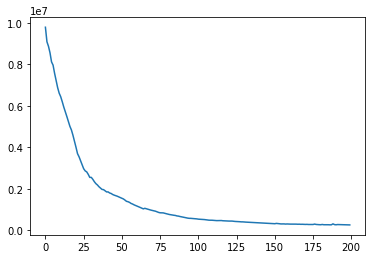

In [12]:
plt.plot(train_elbo)

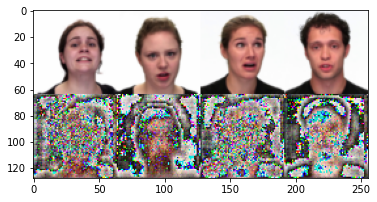

In [13]:
NUM_SAMPLES = 4
input_array = np.zeros(shape=(IMG_SIZE, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_SIZE, 1, 3), dtype="uint8")
    
# pick NUM_SAMPLES random test images from the first mini-batch and
# visualize how well we're reconstructing them

faces = next(iter(dataset_loader))['image']
if args.cuda:
    faces = faces.cuda()

reco_indices = np.random.randint(0, faces.size(0), NUM_SAMPLES)
for index in reco_indices:
    input_img = faces[index, :]
    # storing the input image
    input_img_display = np.array(input_img.cpu()*255., dtype='uint8')
    input_img_display = input_img_display.transpose((1, 2, 0))
    input_array = np.concatenate((input_array, input_img_display), axis=1)

    # generating the reconstructed image and adding to array
    input_img = input_img.view(1, 3, IMG_SIZE, IMG_SIZE)
    reconstructed_img = mvae.reconstruct_img_nosample(input_img)
    reconstructed_img = reconstructed_img.cpu().view(3, IMG_SIZE, IMG_SIZE).detach().numpy()
    reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
    reconstructed_img = reconstructed_img.transpose((1, 2, 0))
    reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

from PIL import Image

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
plt.imshow(display_array)

In [14]:
import os

# save model if you decide to modify the above code to train your own model
savemodel = True
if savemodel:
    if not os.path.exists('./trained_models'):
      os.mkdir('./trained_models')
    pyro.get_param_store().save('trained_models/mvae_pretrained_06.save')

In [15]:
def after_conv_shape(H):
    kernel_size, stride, padding = 4, 2, 1

    H =  (H - (kernel_size) + 2*padding) / stride + 1
    H =  (H - (kernel_size) + 2*padding) / stride + 1
    H =  (H - (kernel_size) + 2*padding) / stride + 1

    kernel_size, stride, padding = 4, 1, 0

    H =  (H - (kernel_size) + 2*padding) / stride + 1
    return H

model 01 best average training loss: 1,576,161.5907 

model 02 best average training loss: 172,697.4563

model 03 best average training loss: 139,043.5672 

model 04 best average training loss: 94,513.5690 - size 64 (50 epochs)

model 05 best average training loss: 62,957.7892 - size 64 (100 epochs)